In [1]:
import pandas as pd
import numpy as np
#import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('course_lead_scoring.csv')

df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Deal with Null Values

## Data preparation

Check if the missing values are presented in the features.

If there are missing values:

For caterogiral features, replace them with 'NA'

For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use 

train_test_split function for that with random_state=1

In [3]:
## Categorical Values

categorical = df.dtypes[df.dtypes=='object'].index.to_list()
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [4]:
## Numerical values
numerical = df.dtypes[(df.dtypes=='int64')|(df.dtypes=='float64')].index.to_list()

numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [32]:
## these are all categorical Null Values
df.loc[:,categorical].isnull().sum()

lead_source          128
industry             134
employment_status    100
location              63
dtype: int64

In [5]:
## Fillna() on the subset of columns that are categorical
df[categorical] = df[categorical].fillna('NA')

In [6]:
## Fillna() on the subset of columns that are numerical
df[numerical] = df[numerical].fillna(0.0)

df[numerical].isnull().sum()

number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
## DROP 'CONVERTED' FROM LIST OF NUMERICAL COLUMNS SINCE THIS IS THE "Y" VARIABLE
numerical = [i for i in numerical if i != 'converted']
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

## Train Test Split 

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 

Use train_test_split function for that with random_state=1

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

# QUESTION 1 ROC AUC feature importance


In [15]:
from sklearn.metrics import roc_auc_score


In [16]:
df[numerical].head(3)

,number_of_courses_viewed,annual_income,interaction_count,lead_score
0,1,79450.0,4,0.94
1,1,46992.0,1,0.80
2,5,78796.0,3,0.69


In [17]:
## calculate ROC AUC score for each numerical feature using training set
roc_auc_score(y_train, df_train['number_of_courses_viewed'])

0.7635680590007088

In [18]:
## For Loop to calculate every numerical feature's ROC AUC score
auc_dict = {}
for col in df[numerical].columns.to_list():
    auc_score = roc_auc_score(y_train, df_train[col])
    auc_dict[col] = auc_score

## Store in DataFrame
df_auc = pd.DataFrame.from_dict(auc_dict, orient='index', columns=['AUC']).sort_values(by='AUC', ascending=False)
df_auc

,AUC
number_of_courses_viewed,0.763568
interaction_count,0.738270
lead_score,0.614499
annual_income,0.551958


### QUESTION 1 ANSWER = number of courses viewed has highest ROC AUC score

# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with 

these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [49]:
## instantiate Vectorizer model
dv = DictVectorizer(sparse=False)

## Create dictionary 
train_dict = df_train[categorical + numerical].to_dict(orient='records')

## Vectorize Features 
    ## fit & transform dictionary to vectorizer model
X_train = dv.fit_transform(train_dict)

## Create Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)   ## train model

## Vectorize Validation dataset
dicts = df_val.to_dict(orient='records')
X_val = dv.transform(dicts)

## Generate Model predictions on Validations dataset
y_pred = model.predict_proba(X_val)[:,1]


In [50]:
round(roc_auc_score(y_val, y_pred),3)

0.856

### QUESTION #2 ANSWER = AUC of the model is 0.856

# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall

Plot them

At which threshold precision and recall curves intersect?

In [22]:
scores = []

thresholds = np.arange(0.0, 1.01, 0.01)    #array to iterate through various thresholds in step 0.01

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [23]:
## Create DataFrame to hold results
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [24]:
df_scores.head(3)

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,171,122,0,0,1.0,1.0
1,0.01,171,122,0,0,1.0,1.0
2,0.02,171,122,0,0,1.0,1.0


In [25]:
## Calculate Precision and Recall
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

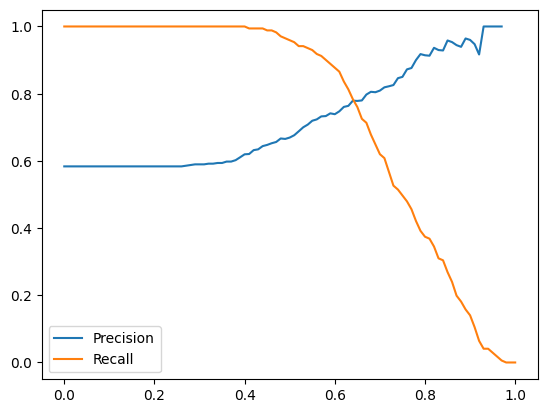

In [26]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

### QUESTION #3 ANSWER = Precision and Recall curves intersect at threshold 0.745

# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. 

That's why they are often combined into the F1 score - a metrics that takes into 

account both

This is the formula for computing F1:     

2 * (P*R) / (P+R)


Where 
P is precision and 

R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [27]:
df_scores.head(3)

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.00,171,122,0,0,1.0,1.0,0.583618,1.0
1,0.01,171,122,0,0,1.0,1.0,0.583618,1.0
2,0.02,171,122,0,0,1.0,1.0,0.583618,1.0


In [28]:
df_scores['F1'] = (2* 
                   (df_scores['precision']*df_scores['recall'])/
                   (df_scores['precision'] + df_scores['recall'])
                  )

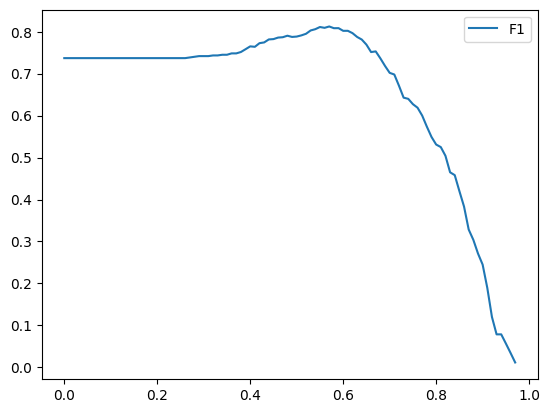

In [29]:
## Plot F1
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')
plt.legend()

### QUESTION #4 ANSWER = F1 IS MAXIMIZED AT THE 0.54 THRESHOLD LEVEL

# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, 

max_iter=1000)

Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [34]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold


In [31]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [32]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [43]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


# Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]

Initialize KFold with the same parameters as previously

Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [46]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036


### QUESTION #6 ANSWER = Regularization Hyperparameter C = 0.001 has the best mean AUC score of 0.867